# A Simpler Method for Understanding Emergency Shelter Access Patterns

    Copyright (C) 2022 Geoffrey Guy Messier

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import datetime, copy, imp
import time
import os
import re
import dask.dataframe as dd

from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

from pandas.tseries.offsets import DateOffset
from sklearn.cluster import KMeans
from util import KMeansCluster as kmGeoff

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

import sys
sys.path.insert(0, '../util/')

%aimport di_data
%aimport data_cache

from di_data import *
from data_cache import CacheResult

In [3]:
dataDirStr = '/Users/gmessier/data/plwh/gb/'
cacheDirStr = '/Users/gmessier/data/plwh/gb/cache/'

## Create Sleep Tables
The event table contains all the individual sleep events indexed by `ClientId` and `Date`.

In [4]:
@CacheResult
def gen_event_table(field):

    # Multiple events in a 24 hour period are counted only once.
    def merge_events_24hr(tbl,field):
        dates = tbl.Date.drop_duplicates()
        nEntry = len(dates)
        return pd.DataFrame({
            'ClientId': [ tbl.iloc[0].ClientId ]*nEntry,
            'Date': dates,
            'EventType': [ field ]*nEntry
        })
    
    rawTblCols = [ 'ClientId', 'Date', 'EventType' ]
    
    rawTbl = pd.read_hdf(dataDirStr + 'Event-Anonymized-UpTo-Q1-2022.hdf', key='Data')   
    rawTbl = rawTbl[rawTblCols]
    rawTbl = rawTbl.assign(Date = rawTbl.Date.dt.normalize())
    
    tbl = rawTbl.loc[ rawTbl.EventType == field ].groupby('ClientId').progress_apply(merge_events_24hr,field=field).reset_index(drop=True)
    
    return tbl    
    

In [5]:
eTbl = gen_event_table('Sleep',path=cacheDirStr,filename='Metrics-EventTable.hdf')

Access and episode sequences are lists that give the date and index number of individual shelter sleeps and episodes of shelter sleeps, respectively.

In [6]:
def calculate_access_sequence(tbl,field):
    
    validRecs =  tbl.EventType == field
    dates = tbl.loc[validRecs].Date.drop_duplicates().sort_values() 
    
    return pd.DataFrame({
        'Date': dates.values,                 # Date of each access.
        'Ind': range(1,len(dates)+1)   # Index of each access.
    },index = range(0,len(dates)))

In [7]:
episodeGap = 30  # Min number of days between episodes.

def calculate_episode_sequence(tbl,field):    
    
    validRecs = tbl.EventType == field
    accDates = tbl.loc[validRecs].Date.drop_duplicates().sort_values() 
    
    gapVals = accDates.diff().astype('timedelta64[D]')
    gapInd = (gapVals >= episodeGap).astype('int').cumsum().drop_duplicates(keep='first')
    
    return pd.DataFrame({
        'Date': tbl.loc[gapInd.index].Date.values, # Date of first day of each episode.
        'Ind': range(1,len(gapInd)+1)       # Episode index.
    },index=range(0,len(gapInd)))


In [8]:
@CacheResult
def gen_access_pattern_table(tbl,typeStr):
    
    acc = tbl.groupby('ClientId').progress_apply(calculate_access_sequence,field=typeStr)        
    epi = tbl.groupby('ClientId').progress_apply(calculate_episode_sequence,field=typeStr) 

    lastAcc = acc.groupby(level=0).max()
    firstAcc = acc.groupby(level=0).min()
    lastEpi = epi.groupby(level=0).max()

    return pd.DataFrame({
        'NAcc': lastAcc.Ind,
        'NEpi': lastEpi.Ind,
        'StartDate': firstAcc.Date,
        'EndDate': lastAcc.Date,
    })

In [9]:
sleepTbl = gen_access_pattern_table(eTbl, typeStr='Sleep', path=cacheDirStr, filename='Metrics-SleepTable.hdf')

In [10]:
studyStartDate = pd.to_datetime('2009-07-01')
studyEndDate = pd.to_datetime('2022-03-31')

validClients = ((sleepTbl.StartDate >= studyStartDate) & (sleepTbl.EndDate <= studyEndDate))
sleepTbl = sleepTbl.loc[validClients]

nEntry = (eTbl.ClientId.isin(sleepTbl.index)).sum()

print(f'Clients: {len(sleepTbl.index)}, Entries: {nEntry}')


Clients: 24512, Entries: 1904044


## Define Eras
- Define a cohort of clients with record start/end dates that fit within each era.

In [11]:
eraDates = {
    'HousingReady':  { 'start': pd.to_datetime('2009-07-01'), 'end': pd.to_datetime('2017-07-31') },
    'All' : { 'start': studyStartDate, 'end': studyEndDate }
}

In [12]:
def create_cohorts(era, tbl):
    nClient = len(tbl.index)
    cohort = {}
    for e in era.keys():
        cohort[e] = tbl.loc[ (tbl.StartDate >= era[e]['start']) & (tbl.EndDate <= era[e]['end']) ].index
        print(f'{e} Cohort Size: {len(cohort[e])}/{nClient} ({100*len(cohort[e])/nClient:.2f}%)')
    return cohort

In [13]:
cohort = create_cohorts(eraDates, sleepTbl)

HousingReady Cohort Size: 13295/24512 (54.24%)
All Cohort Size: 24512/24512 (100.00%)


## Clustering

In [14]:
def generate_cluster_cohorts(cohort,tbl):

    cohortClstr = { k : {} for k in cohort.keys() }

    for k in cohort.keys():

        idx = tbl.index.isin(cohort[k])

        dat = tbl.loc[idx][ [ 'NAcc', 'NEpi' ] ].to_numpy()
        nrm = (dat - dat.mean(axis=0))/np.sqrt(dat.var(axis=0))

        kmeans = KMeans(n_clusters=3, random_state=0).fit(nrm)
        labels = kmeans.labels_
        srtInds = np.argsort(kmeans.cluster_centers_[:,0])

        print(f'--- {k} ---')
        nTot = sum(idx)

        cStr = [ 'Trn', 'Epi', 'Chr' ]
        for cInd in range(len(cStr)):
            cohortClstr[k][cStr[cInd]] = tbl.loc[idx].loc[labels == srtInds[cInd]].index.to_numpy()
            nCoh = sum(labels == srtInds[cInd])
            print(f' {cStr[cInd]}: {nCoh}/{nTot} ({100*nCoh/nTot:.2f}%)')

    
    return cohortClstr



In [15]:
clstr = generate_cluster_cohorts(cohort,sleepTbl)

--- HousingReady ---
 Trn: 11984/13295 (90.14%)
 Epi: 1092/13295 (8.21%)
 Chr: 219/13295 (1.65%)
--- All ---
 Trn: 21211/24512 (86.53%)
 Epi: 2713/24512 (11.07%)
 Chr: 588/24512 (2.40%)


## SAM

In [16]:
def calc_sam_metrics(tbl,obsWin,actvThrsh):
    
    duration = np.nan
    inShelterFrc = np.nan
    
    daysInShelter = (tbl.Date - tbl.Date.min()).dt.days    
    
    obsDay = daysInShelter.loc[ (daysInShelter <= obsWin) & (daysInShelter > obsWin - actvThrsh) ].max()
    
    if(obsDay != obsDay):
        valid = False
        
    else:
        valid = True
        duration = obsDay
        nAccesses = tbl.loc[daysInShelter < obsDay].EventType.count() 
        inShelterFrc = nAccesses / duration
        
    return pd.Series({ 'StartDate': tbl.Date.min(), 'Valid': valid, 'Duration': duration, 'InShelterFrc': inShelterFrc })


In [17]:
idx = eTbl.ClientId.isin(cohort['HousingReady']) & (eTbl.EventType == 'Sleep')
samMets = eTbl.loc[idx].groupby('ClientId').progress_apply(calc_sam_metrics,obsWin=90,actvThrsh=30)

  0%|          | 0/13295 [00:00<?, ?it/s]

## Evaluate SAM

### Accuracy

In [18]:
trueLbl = clstr['HousingReady']   # Assume the cluster labels are "true".

In [19]:
nClients = len(cohort['HousingReady'])

In [20]:
def assign_sam_labels(alpha, mets):
    coh = {}

    # Inactive clients are considered transitional.
    coh['Trn'] = list( mets.loc[ ~mets.Valid ].index )

    # Active clients above/below threshold are frequent/infrequent.
    coh['Chr'] = list( mets.loc[ mets.Valid & (mets.InShelterFrc > alpha) ].index )
    coh['Epi'] = list( mets.loc[ mets.Valid & (mets.InShelterFrc <= alpha) ].index )
    
    return coh

In [21]:
def calc_confusion_matrix(alpha,mets,trueLbl):

    hatLbl = assign_sam_labels(alpha,mets)
    
    cMtx = np.zeros((3,3),dtype='int')
    key = [ 'Trn', 'Epi', 'Chr' ]
    for i in range(3):
        for j in range(3):
            cMtx[i,j] = np.isin(hatLbl[key[i]],trueLbl[key[j]]).sum()

    return cMtx

In [22]:
def sweep_alpha(alphas, mets, trueLbl):

    res = np.empty((0,2))
    pbar = tqdm(total=len(alphas))
    for alpha in alphas:
            
        cMtx = calc_confusion_matrix(alpha,mets,trueLbl)

        acc = cMtx.diagonal().sum()/cMtx.sum().sum()

        nuRes = [[ alpha, acc ]]

        res = np.append(res,nuRes,axis=0)
        pbar.update(1)

    pbar.close()

    return res


In [23]:
sweepRes = sweep_alpha(
    alphas = np.arange(0.05,1,0.05), 
    mets = samMets, trueLbl = trueLbl)

  0%|          | 0/19 [00:00<?, ?it/s]

In [24]:
# Select the value of alpha that gives maximum accuracy.
mxAcc = np.argmax(sweepRes[:,1])
print(f'Max Accuracy: {sweepRes[mxAcc,1]:.3f} (alpha = {sweepRes[mxAcc,0]:.2f})')

Max Accuracy: 0.816 (alpha = 0.85)


### Shelter Access Characteristics

In [25]:
samLbl = assign_sam_labels(alpha = 0.85, mets = samMets)

In [26]:
def gen_access_stats(coh,tbl):
    cohTbl = tbl.loc[tbl.index.isin(coh)]
    
    stats = {}
    n = len(coh)
    stats['N'] = n
    
    stats['NAccMn'] = cohTbl.NAcc.mean()
    stats['NAccMd'] = cohTbl.NAcc.median()
    stats['NAcc10'] = cohTbl.NAcc.sort_values(ascending=False).iloc[int(n*0.1)]
    
    stats['NEpiMn'] = cohTbl.NEpi.mean()
    stats['NEpiMd'] = cohTbl.NEpi.median()
    stats['NEpi10'] = cohTbl.NEpi.sort_values(ascending=False).iloc[int(n*0.1)]
    
    return stats

In [27]:
def gen_header(lWdth,cWdth,sepStr=' ',endStr=''):
    
    hStr = f'{" ":>{lWdth}}' + sepStr
    hStr += f'{" ":^{cWdth}}' + sepStr
    hStr += f'{"Stays":^{cWdth}}' + sepStr
    hStr += f'{"Episodes":^{cWdth}}' 
    hStr += endStr + '\n'
    
    hStr += f'{" ":>{lWdth}}' + sepStr
    hStr += f'{"N":^{cWdth}}' + sepStr
    hStr += f'{"(mean/median/10th pctl)":^{cWdth}}' + sepStr
    hStr += f'{"(mean/median/10th pctl)":^{cWdth}}' 
    
    return hStr + endStr

In [28]:
def gen_stat_row(labelStr,stat,nClients,lWdth,cWdth,sepStr=' ',endStr=''):
    
    rStr = f'{labelStr:>{lWdth}}' + sepStr
    nStr = f'{stat["N"]}/{nClients} ({100*stat["N"]/nClients:.2f}\%)'
    rStr += f'{nStr:^{cWdth}}' + sepStr
    
    nStr = f'{stat["NAccMn"]:.2f} / {stat["NAccMd"]:.0f} / {stat["NAcc10"]:.0f}'    
    rStr += f'{nStr:^{cWdth}}' + sepStr
    
    nStr = f'{stat["NEpiMn"]:.2f} / {stat["NEpiMd"]:.0f} / {stat["NEpi10"]:.0f}'    
    rStr += f'{nStr:^{cWdth}}'

    return rStr + endStr
    
    

In [29]:
labels = { 'Trn': 'Transitional', 'Epi': 'Episodic', 'Chr': 'Chronic' }

lWdth = 24
cWdth = 24

print(gen_header(lWdth,cWdth,sepStr=' & ',endStr='\\\\'))

for k in labels.keys():
    tStat = gen_access_stats(trueLbl[k],sleepTbl)
    eStat = gen_access_stats(samLbl[k],sleepTbl)

    rStr = gen_stat_row(labels[k]+' - cluster',tStat,nClients,lWdth,cWdth,sepStr=' & ',endStr='\\\\')
    print(rStr)
    
    rStr = gen_stat_row(labels[k]+' - SAM',eStat,nClients,lWdth,cWdth,sepStr=' & ',endStr='\\\\')
    print(rStr)
        
    



                         &                          &          Stays           &         Episodes        \\
                         &            N             & (mean/median/10th pctl)  & (mean/median/10th pctl) \\
  Transitional - cluster &  11984/13295 (90.14\%)   &      20.62 / 2 / 53      &       1.52 / 1 / 3      \\
      Transitional - SAM &  11007/13295 (82.79\%)   &      16.29 / 2 / 28      &       1.78 / 1 / 3      \\
      Episodic - cluster &   1092/13295 (8.21\%)    &    115.34 / 65 / 311     &      7.01 / 6 / 10      \\
          Episodic - SAM &   1668/13295 (12.55\%)   &    102.40 / 49 / 255     &       3.36 / 3 / 7      \\
       Chronic - cluster &    219/13295 (1.65\%)    &   1018.11 / 843 / 1782   &       2.50 / 2 / 5      \\
           Chronic - SAM &    620/13295 (4.66\%)    &    396.75 / 218 / 947    &       2.02 / 1 / 4      \\


## Access Pattern Timeline

In [30]:
startDate = pd.to_datetime('2013-08-01')
endDate = pd.to_datetime('2022-02-01')

In [31]:
idx = eTbl.ClientId.isin(cohort['All']) & (eTbl.EventType == 'Sleep')

In [32]:
samMets = eTbl.loc[idx].groupby('ClientId').progress_apply(calc_sam_metrics,obsWin=90,actvThrsh=30)

  0%|          | 0/24512 [00:00<?, ?it/s]

In [33]:
def real_time_sam(tbl,alpha):
    labelStr = 'Trn'
    row = tbl.iloc[0]
    if row.Valid:
        if row.InShelterFrc > alpha:
            labelStr = 'Chr'
        else:
            labelStr = 'Epi'
            
    return pd.Series({ 'Date': row.StartDate, 'Label': labelStr })

In [34]:
labels = samMets.groupby(level=0).progress_apply(real_time_sam,alpha=0.85)

  0%|          | 0/24512 [00:00<?, ?it/s]

In [35]:
dateIdx = (labels.Date >= startDate) & (labels.Date <= endDate)
c = labels.loc[(labels.Label=='Chr') & dateIdx].resample('3M',on='Date').count().Label
e = labels.loc[(labels.Label=='Epi') & dateIdx].resample('3M',on='Date').count().Label
t = labels.loc[(labels.Label=='Trn') & dateIdx].resample('3M',on='Date').count().Label

n = c+e+t

In [36]:
cPct = c/n*100
ePct = e/n*100
tPct = t/n*100

cPctChg = (cPct/cPct.iloc[0]-1)*100
ePctChg = (ePct/ePct.iloc[0]-1)*100
tPctChg = (tPct/tPct.iloc[0]-1)*100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


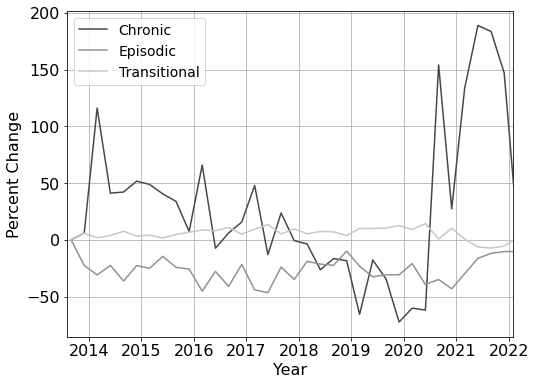

In [42]:
plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(figsize=(8,6))

dates = n.index
plt.plot(dates,cPctChg,color='#474747',label='Chronic')
plt.plot(dates,ePctChg,color='#919191',label='Episodic')
plt.plot(dates,tPctChg,color='#c7c7c7',label='Transitional')
plt.legend(fontsize=14)

plt.ylabel('Percent Change',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.grid()

_ = ax.set_xlim([ startDate, endDate ])
plt.savefig('PercentChange.eps')

## Shelter Usage Timeline

In [38]:
cohT = labels.loc[labels.Label == 'Trn'].index
cohE = labels.loc[labels.Label == 'Epi'].index
cohC = labels.loc[labels.Label == 'Chr'].index

In [39]:
sleepsT = eTbl.loc[eTbl.ClientId.isin(cohT) & (eTbl.Date >= startDate) & (eTbl.Date <= endDate)].resample('3M',on='Date').count().EventType
sleepsE = eTbl.loc[eTbl.ClientId.isin(cohE) & (eTbl.Date >= startDate) & (eTbl.Date <= endDate)].resample('3M',on='Date').count().EventType
sleepsC = eTbl.loc[eTbl.ClientId.isin(cohC) & (eTbl.Date >= startDate) & (eTbl.Date <= endDate)].resample('3M',on='Date').count().EventType
sleepsN = sleepsT + sleepsE + sleepsC

sleepsTPct = sleepsT/sleepsN*100
sleepsEPct = sleepsE/sleepsN*100
sleepsCPct = sleepsC/sleepsN*100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


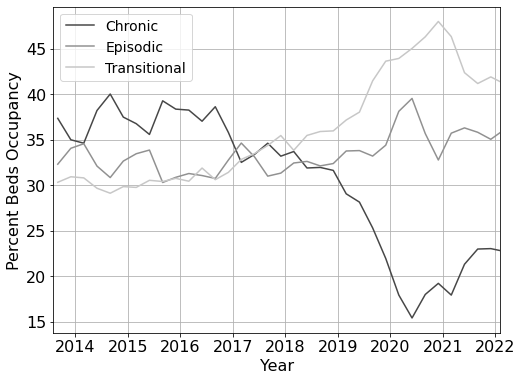

In [40]:
fig,ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = 16
width = 25

dates = sleepsN.index

plt.plot(dates,sleepsCPct,color='#474747',label='Chronic')
plt.plot(dates,sleepsEPct,color='#919191',label='Episodic')
plt.plot(dates,sleepsTPct,color='#c7c7c7',label='Transitional')

plt.legend(fontsize=14)

plt.ylabel('Percent Beds Occupancy',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.grid()

_ = ax.set_xlim([ startDate, endDate ])
plt.savefig('BedOccupancy.eps')